In [1]:
from localgraphclustering import *

import time
import numpy as np

# Import the graph_tool module for visualization.
from graph_tool.all import * 

# Import matplotlib 
import matplotlib.pyplot as plt

# Just a useful function.
def diff(a, b):
        b = set(b)
        return np.asarray([aa for aa in a if aa not in b], dtype = 'int64')

# Load Protein-Protein interaction graph

In [2]:
# Read graph. This also supports gml and graphml format.
# The MIPS Mammalian Protein-Protein Database is a database for protein-protein interactions of mammalian species. 
# We used the data set proposed in consisting of a subset of 220 protein complexes of 1562 proteins. 
# Details can be found here: https://clusteval.sdu.dk/1/datasets/685
g = GraphLocal('./datasets/ppi_mips.graphml','graphml',' ')

/usr/local/lib/python3.6/site-packages/localgraphclustering/GraphLocal.py:203: UserWarning:

Loading a graphml is not efficient, we suggest using an edgelist format for this API.



## Compute layout for visualization

In [3]:
# Add data to graphtool.
g_gtool = load_graph("./datasets/ppi_mips.graphml")
    
remove_self_loops(g_gtool)

# Load pre-computed coordinates for nodes.
ld_coord = np.loadtxt('./datasets/ppi_mips_coordinates.xy', dtype = 'str')

temp = []
for i in ld_coord:
    temp.append(i[0])

idxs = dict(zip(temp, range(len(temp)))) 

pos = g_gtool.new_vertex_property("vector<double>")
for i in ld_coord:
    pos[idxs[i[0]]] = i[1:3]

## Visualize the PPI graph and its ground truth

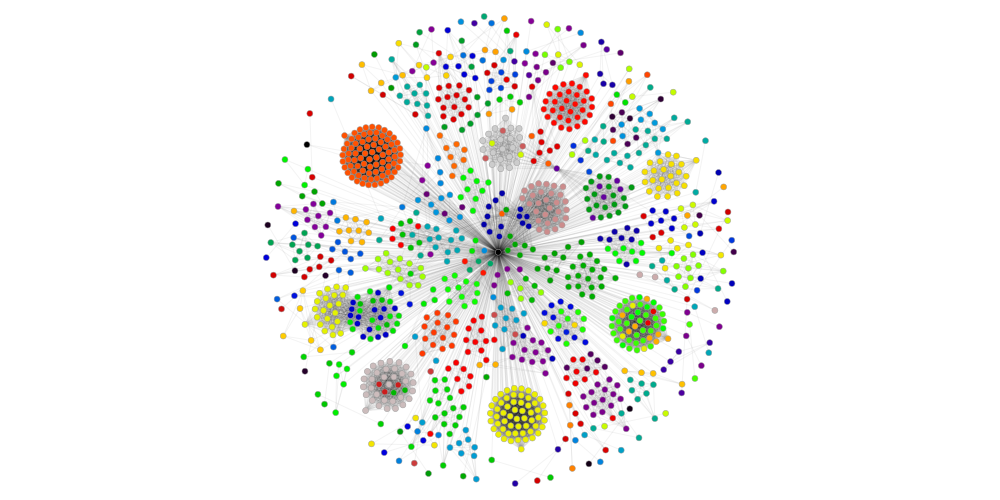

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x12a54ff60, at 0x1102c83c8>

In [4]:
ld_coord = np.loadtxt('./datasets/ppi_mips_ground_truth.csv', dtype = 'str')

cluster_type = []
for i in ld_coord:
    cluster_type.append(i[1])
cluster_type_set = set(cluster_type)

idxs_cluster_type = dict(zip(cluster_type_set, range(len(cluster_type_set)))) 

protein_color = np.zeros(len(cluster_type))
for i in range(len(cluster_type)):
    protein_color[idxs[ld_coord[i][0]]] = idxs_cluster_type[ld_coord[i][1]]
    
# Plot solutions for rounded eigenvector
node_colours = g_gtool.new_vertex_property("double",protein_color)

temp = np.zeros(g._num_vertices) + 6

node_size = g_gtool.new_vertex_property("double",temp)

c_map = plt.get_cmap('nipy_spectral')

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=1,
           edge_color = [0.0, 0, 0, 0.05],
           vcmap = c_map)

## Localized vector using l1-regularized PageRank

In [5]:
# Find the solution of L1-regularized PageRank using localized accelerated gradient descent.
# This method is the fastest among other l1-regularized solvers and other approximate PageRank solvers.
reference_node = [100]
l1_reg_vector = approximate_PageRank(g,reference_node,rho=4.0e-5,method="l1reg")

/usr/local/lib/python3.6/site-packages/localgraphclustering/approximate_PageRank.py:109: UserWarning:

The weights of the graph will be discarded. Use approximate_PageRank_weighted instead if you want to keep the edge weights.



## Visualize the solution

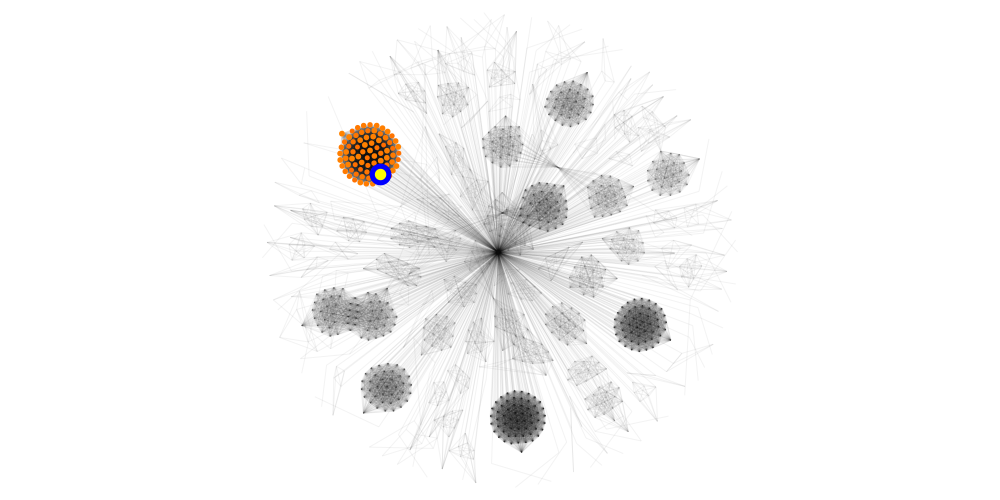

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x12a54ff60, at 0x1102c83c8>

In [6]:
# Some pre-processing to make visualization better.
temp = np.copy(l1_reg_vector)
nnz_temp = temp.nonzero()
nnz_temp = nnz_temp[0]
temp[nnz_temp] = -np.log(temp[nnz_temp])
temp[nnz_temp] = 100/temp[nnz_temp]
temp = temp + 0.0001
max_all = max(temp)
temp[reference_node] = max_all/2.6
temp = temp/np.linalg.norm(temp, 2)

halo = np.zeros(g._num_vertices, dtype=bool)
halo[reference_node] = True
node_halo   = g_gtool.new_vertex_property("bool",halo)

node_weights = g_gtool.new_vertex_property("double",temp)
node_size = g_gtool.new_vertex_property("double",np.abs(temp)*50)

c_map = plt.get_cmap('autumn')

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, vertex_fill_color=node_weights, vorder=node_size,
           vertex_halo=node_halo,
           vertex_halo_size = 1.9,
           vertex_halo_color = "blue",
           edge_pen_width=1,
           edge_color = [0.0, 0, 0, 0.05],
           vcmap = c_map)

## Obtain the partition using the localized vector from l1-regularized PageRank

In [7]:
# Call C++ version of sweep cut rounding on the l1-regularized PageRank solution.
output_sc_fast = sweep_cut(g,l1_reg_vector)

# Extract the partition for g and store it.
l1_reg_vector_rounded = output_sc_fast[0]

## Visualize local partitioning

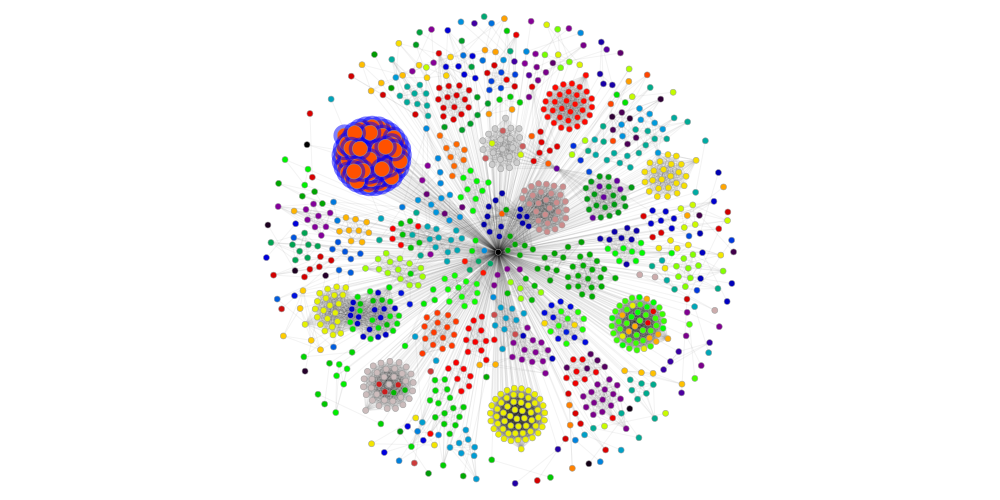

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x12a54ff60, at 0x1102c83c8>

In [8]:
# Plot solutions for rounded eigenvector
temp = np.zeros(g._num_vertices) + 6

temp[l1_reg_vector_rounded] = 15

node_size = g_gtool.new_vertex_property("double",temp)

halo = np.zeros(g._num_vertices, dtype=bool)
halo[l1_reg_vector_rounded] = True
node_halo   = g_gtool.new_vertex_property("bool",halo)

c_map = plt.get_cmap('nipy_spectral')

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           vertex_halo=node_halo,
           edge_pen_width=1,
           edge_color = [0.0, 0, 0, 0.05],
           vcmap = c_map)

# Load Blasted Sequences graph

In [9]:
# Read graph. This also supports gml and graphml format.
# The data set contains pairwise similarities of blasted 
# sequences of 232 proteins belonging to the amidohydrolase superfamily. 
g = GraphLocal('./datasets/sfld_brown_et_al_amidohydrolases_protein_similarities_for_beh.graphml','graphml',' ')

/usr/local/lib/python3.6/site-packages/localgraphclustering/GraphLocal.py:203: UserWarning:

Loading a graphml is not efficient, we suggest using an edgelist format for this API.



## Compute layout for visualization

In [10]:
# Add data to graphtool.
g_gtool = load_graph("./datasets/sfld_brown_et_al_amidohydrolases_protein_similarities_for_beh.graphml")
    
remove_self_loops(g_gtool)

# Load pre-computed coordinates for nodes.
ld_coord = np.loadtxt('./datasets/sfld_brown_et_al_amidohydrolases_protein_similarities_for_beh_coordinates.xy', dtype = 'str')

temp = []
for i in ld_coord:
    temp.append(i[0])

idxs = dict(zip(temp, range(len(temp)))) 

pos = g_gtool.new_vertex_property("vector<double>")
for i in ld_coord:
    pos[idxs[i[0]]] = i[1:3]

## Visualize the Blasted Sequences graph

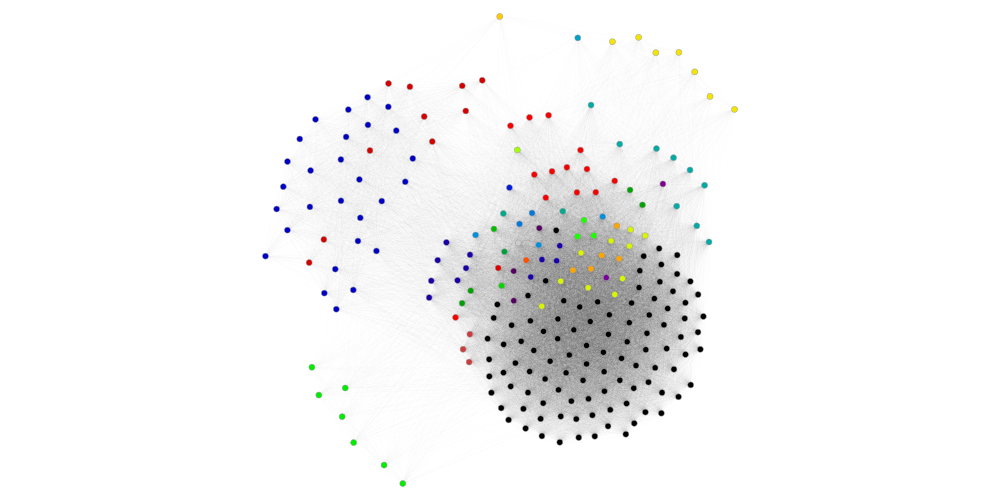

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x137862cf8, at 0x137d016a0>

In [11]:
ld_coord = np.loadtxt('./datasets/sfld_brown_et_al_amidohydrolases_protein_similarities_for_beh_ground_truth.csv', dtype = 'str')

cluster_type = []
for i in ld_coord:
    cluster_type.append(i[1])
cluster_type_set = set(cluster_type)

idxs_cluster_type = dict(zip(cluster_type_set, range(len(cluster_type_set)))) 

protein_color = np.zeros(len(cluster_type))
for i in range(len(cluster_type)):
    protein_color[idxs[ld_coord[i][0]]] = idxs_cluster_type[ld_coord[i][1]]
    
# Plot solutions for rounded eigenvector
node_colours = g_gtool.new_vertex_property("double",protein_color)

temp = np.zeros(g._num_vertices) + 6

node_size = g_gtool.new_vertex_property("double",temp)

c_map = plt.get_cmap('nipy_spectral')

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=0.1,
           edge_color = [0.0, 0, 0, 0.05],
           vcmap = c_map)

## Localized vector using l1-regularized PageRank

In [12]:
# Find the solution of L1-regularized PageRank using localized accelerated gradient descent.
# This method is the fastest among other l1-regularized solvers and other approximate PageRank solvers.
reference_node = [218]
l1_reg_vector = approximate_PageRank(g,reference_node,rho=1.0e-4,method="l1reg")

## Visualize the solution

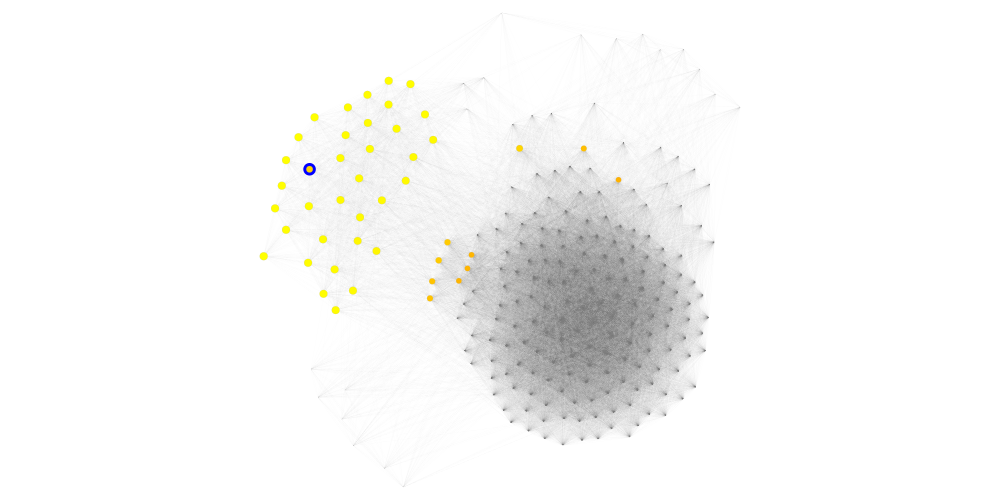

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x137862cf8, at 0x137d016a0>

In [13]:
# Some pre-processing to make visualization better.
temp = np.copy(l1_reg_vector)
nnz_temp = temp.nonzero()
nnz_temp = nnz_temp[0]
temp[nnz_temp] = -np.log(temp[nnz_temp])
temp[nnz_temp] = 100/temp[nnz_temp]
temp = temp + 0.0001
max_all = max(temp)
temp[reference_node] = max_all/5
temp = temp/np.linalg.norm(temp, 2)

halo = np.zeros(g._num_vertices, dtype=bool)
halo[reference_node] = True
node_halo   = g_gtool.new_vertex_property("bool",halo)

node_weights = g_gtool.new_vertex_property("double",temp)
node_size = g_gtool.new_vertex_property("double",np.abs(temp)*50)

c_map = plt.get_cmap('autumn')

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, vertex_fill_color=node_weights, vorder=node_size,
           vertex_halo=node_halo,
           vertex_halo_size = 1.9,
           vertex_halo_color = "blue",
           edge_pen_width=0.1,
           edge_color = [0.0, 0, 0, 0.05],
           vcmap = c_map)

## Obtain the partition using the localized vector from l1-regularized PageRank

In [14]:
# Call C++ version of sweep cut rounding on the l1-regularized PageRank solution.
output_sc_fast = sweep_cut(g,l1_reg_vector)

# Extract the partition for g and store it.
l1_reg_vector_rounded = output_sc_fast[0]

## Visualize local partitioning

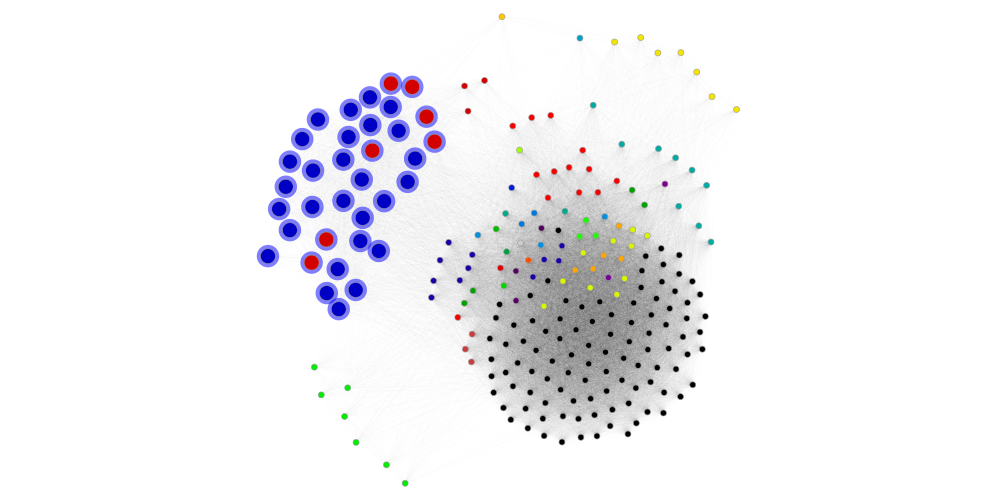

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x137862cf8, at 0x137d016a0>

In [15]:
# Plot solutions for rounded eigenvector
temp = np.zeros(g._num_vertices) + 6

temp[l1_reg_vector_rounded] = 15

node_size = g_gtool.new_vertex_property("double",temp)

halo = np.zeros(g._num_vertices, dtype=bool)
halo[l1_reg_vector_rounded] = True
node_halo   = g_gtool.new_vertex_property("bool",halo)

c_map = plt.get_cmap('nipy_spectral')

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           vertex_halo=node_halo,
           edge_pen_width=0.1,
           edge_color = [0.0, 0, 0, 0.05],
           vcmap = c_map)

## Localized vector using l1-regularized PageRank

In [16]:
# Find the solution of L1-regularized PageRank using localized accelerated gradient descent.
# This method is the fastest among other l1-regularized solvers and other approximate PageRank solvers.
reference_node = [84]
l1_reg_vector = approximate_PageRank(g,reference_node,rho=1.8e-5,method="l1reg")

## Visualize the solution

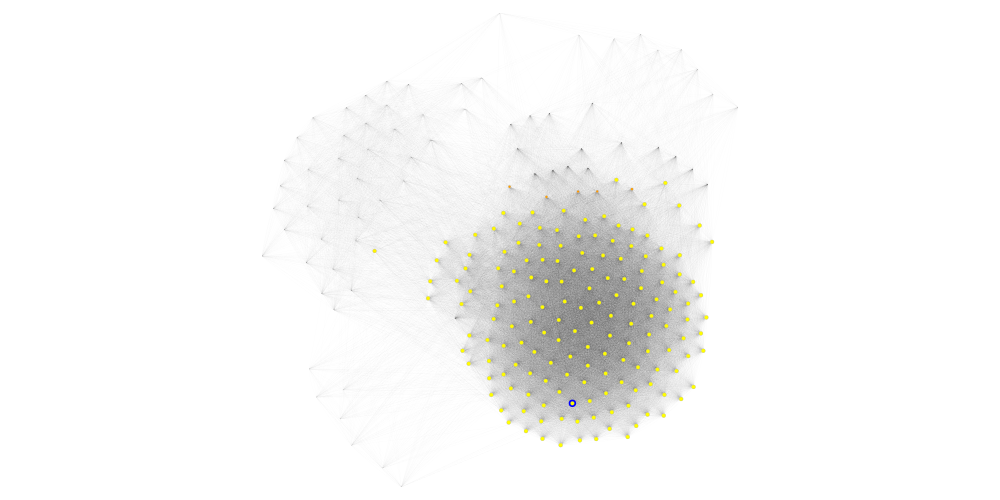

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x137862cf8, at 0x137d016a0>

In [17]:
# Some pre-processing to make visualization better.
temp = np.copy(l1_reg_vector)
nnz_temp = temp.nonzero()
nnz_temp = nnz_temp[0]
temp[nnz_temp] = -np.log(temp[nnz_temp])
temp[nnz_temp] = 100/temp[nnz_temp]
temp = temp + 0.0001
max_all = max(temp)
temp[reference_node] = max_all/5
temp = temp/np.linalg.norm(temp, 2)

halo = np.zeros(g._num_vertices, dtype=bool)
halo[reference_node] = True
node_halo   = g_gtool.new_vertex_property("bool",halo)

node_weights = g_gtool.new_vertex_property("double",temp)
node_size = g_gtool.new_vertex_property("double",np.abs(temp)*50)

c_map = plt.get_cmap('autumn')

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, vertex_fill_color=node_weights, vorder=node_size,
           vertex_halo=node_halo,
           vertex_halo_size = 1.9,
           vertex_halo_color = "blue",
           edge_pen_width=0.1,
           edge_color = [0.0, 0, 0, 0.05],
           vcmap = c_map)

## Obtain the partition using the localized vector from l1-regularized PageRank

In [18]:
# Call C++ version of sweep cut rounding on the l1-regularized PageRank solution.
# Turning off normalization seems to give better results.
output_sc_fast = sweep_cut(g,l1_reg_vector,normalized=False)

# Extract the partition for g and store it.
l1_reg_vector_rounded = output_sc_fast[0]

## Visualize local partitioning

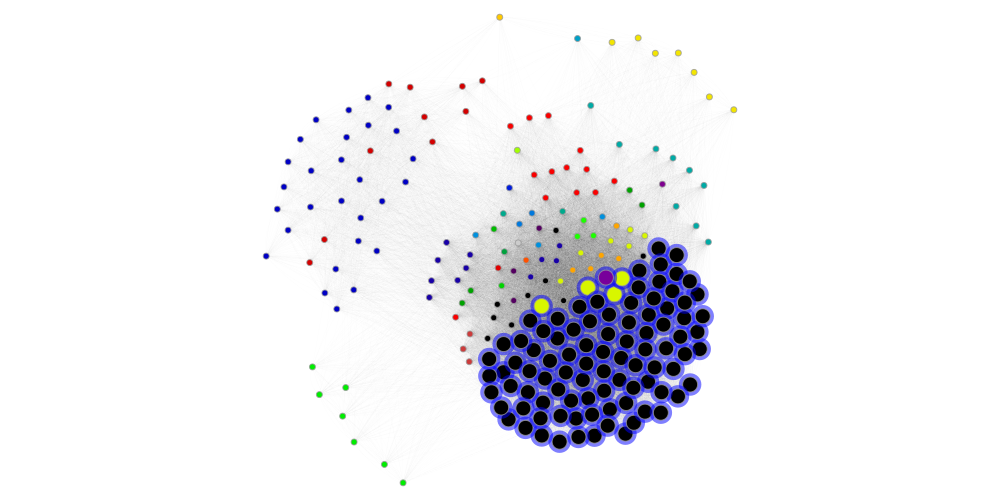

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x137862cf8, at 0x137d016a0>

In [19]:
# Plot solutions for rounded eigenvector
temp = np.zeros(g._num_vertices) + 6

temp[l1_reg_vector_rounded] = 15

node_size = g_gtool.new_vertex_property("double",temp)

halo = np.zeros(g._num_vertices, dtype=bool)
halo[l1_reg_vector_rounded] = True
node_halo   = g_gtool.new_vertex_property("bool",halo)

c_map = plt.get_cmap('nipy_spectral')

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           vertex_halo=node_halo,
           edge_pen_width=0.1,
           edge_color = [0.0, 0, 0, 0.05],
           vcmap = c_map)

# Load Protein structure similarity graph

In [20]:
# Read graph. This also supports gml and graphml format.
# Details for this dataset can be found here: https://clusteval.sdu.dk/1/datasets/981 
g = GraphLocal('./datasets/ASTRAL-small-sized-mammoth-sims-geq-2.graphml','graphml',' ')

/usr/local/lib/python3.6/site-packages/localgraphclustering/GraphLocal.py:203: UserWarning:

Loading a graphml is not efficient, we suggest using an edgelist format for this API.



## Compute layout for visualization

In [21]:
# Add data to graphtool.
g_gtool = load_graph("./datasets/ASTRAL-small-sized-mammoth-sims-geq-2.graphml")
    
remove_self_loops(g_gtool)

# Load pre-computed coordinates for nodes.
ld_coord = np.loadtxt('./datasets/ASTRAL-small-sized-mammoth-sims-geq-2.xy', dtype = 'str')

temp = []
for i in ld_coord:
    temp.append(i[0])

idxs = dict(zip(temp, range(len(temp)))) 

pos = g_gtool.new_vertex_property("vector<double>")
for i in ld_coord:
    pos[idxs[i[0]]] = i[1:3]

## Visualize the graph ground truth

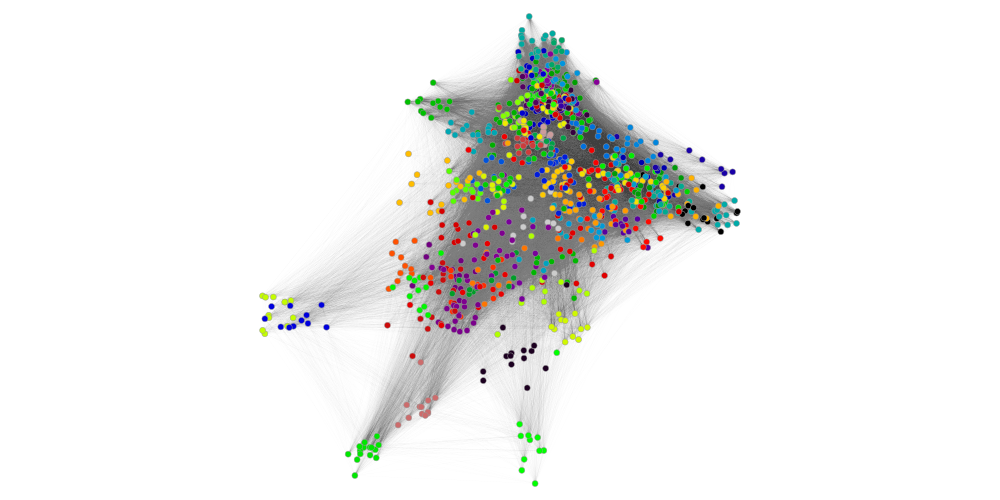

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x137ff5fd0, at 0x10fc079b0>

In [22]:
ld_coord = np.loadtxt('./datasets/ASTRAL-small-sized-mammoth-sims-geq-2_groundTruth.csv', dtype = 'str')

cluster_type = []
for i in ld_coord:
    cluster_type.append(i[1])
cluster_type_set = set(cluster_type)

idxs_cluster_type = dict(zip(cluster_type_set, range(len(cluster_type_set)))) 

protein_color = np.zeros(len(cluster_type))
for i in range(len(cluster_type)):
    protein_color[idxs[ld_coord[i][0]]] = idxs_cluster_type[ld_coord[i][1]]
    
# Plot solutions for rounded eigenvector
node_colours = g_gtool.new_vertex_property("double",protein_color)

temp = np.zeros(g._num_vertices) + 6

node_size = g_gtool.new_vertex_property("double",temp)

c_map = plt.get_cmap('nipy_spectral')

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=0.1,
           edge_color = [0.0, 0, 0, 0.05],
           vcmap = c_map)

## Localized vector using l1-regularized PageRank

In [23]:
# Find the solution of L1-regularized PageRank using localized accelerated gradient descent.
# This method is the fastest among other l1-regularized solvers and other approximate PageRank solvers.
reference_node = [772]
l1_reg_vector = approximate_PageRank(g,reference_node,rho=6.5e-6,method="l1reg")

/usr/local/lib/python3.6/site-packages/localgraphclustering/approximate_PageRank.py:109: UserWarning:

The weights of the graph will be discarded. Use approximate_PageRank_weighted instead if you want to keep the edge weights.



## Obtain the partition using the localized vector from l1-regularized PageRank

In [24]:
# Call C++ version of sweep cut rounding on the l1-regularized PageRank solution.
output_sc_fast = sweep_cut(g,l1_reg_vector)

# Extract the partition for g and store it.
l1_reg_vector_rounded_1 = output_sc_fast[0]

## Visualize local partitioning

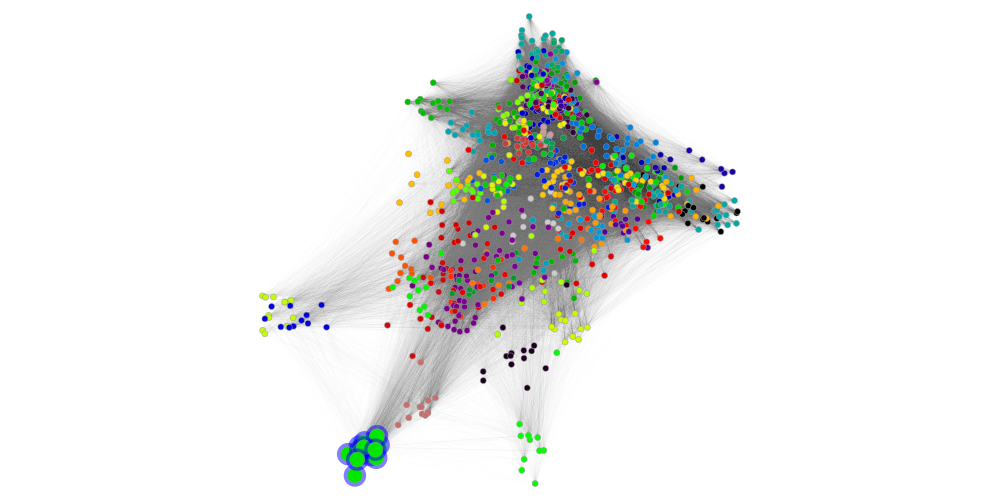

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x137ff5fd0, at 0x10fc079b0>

In [25]:
# Plot solutions for rounded eigenvector
temp = np.zeros(g._num_vertices) + 6

temp[l1_reg_vector_rounded_1] = 15

node_size = g_gtool.new_vertex_property("double",temp)

halo = np.zeros(g._num_vertices, dtype=bool)
halo[l1_reg_vector_rounded_1] = True
node_halo   = g_gtool.new_vertex_property("bool",halo)

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           vertex_halo=node_halo,
           edge_pen_width=0.1,
           edge_color = [0.0, 0, 0, 0.05],
           vcmap = c_map)

## Localized vector using l1-regularized PageRank

In [26]:
# Find the solution of L1-regularized PageRank using localized accelerated gradient descent.
# This method is the fastest among other l1-regularized solvers and other approximate PageRank solvers.
reference_node = [206]
l1_reg_vector = approximate_PageRank(g,reference_node,rho=1.957e-5,method="l1reg")

/usr/local/lib/python3.6/site-packages/localgraphclustering/approximate_PageRank.py:109: UserWarning:

The weights of the graph will be discarded. Use approximate_PageRank_weighted instead if you want to keep the edge weights.



## Obtain the partition using the localized vector from l1-regularized PageRank

In [27]:
# Call C++ version of sweep cut rounding on the l1-regularized PageRank solution.
output_sc_fast = sweep_cut(g,l1_reg_vector)

# Extract the partition for g and store it.
l1_reg_vector_rounded_2 = output_sc_fast[0]

## Visualize local partitioning

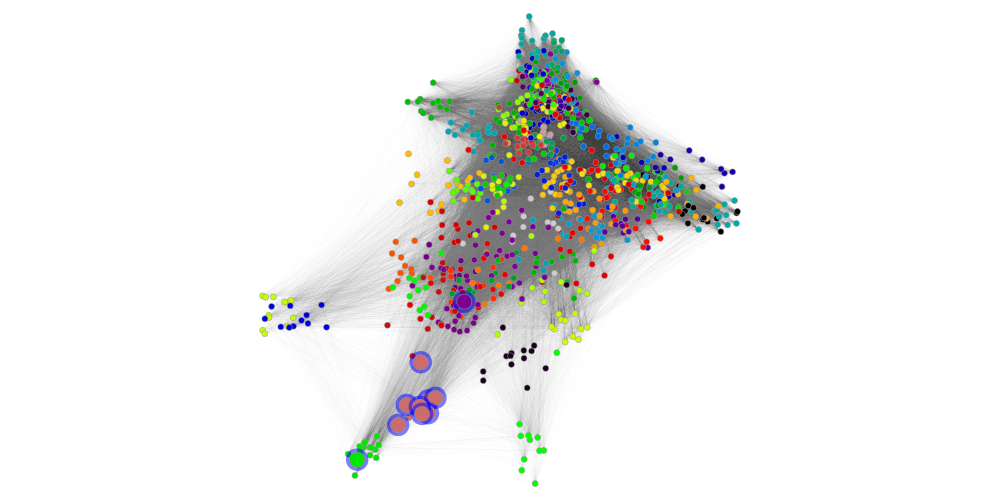

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x137ff5fd0, at 0x10fc079b0>

In [28]:
# Plot solutions for rounded eigenvector
temp = np.zeros(g._num_vertices) + 6

temp[l1_reg_vector_rounded_2] = 15

node_size = g_gtool.new_vertex_property("double",temp)

halo = np.zeros(g._num_vertices, dtype=bool)
halo[l1_reg_vector_rounded_2] = True
node_halo   = g_gtool.new_vertex_property("bool",halo)

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           vertex_halo=node_halo,
           edge_pen_width=0.1,
           edge_color = [0.0, 0, 0, 0.05],
           vcmap = c_map)